In [209]:
import math
import numpy as np

class Value():
    """
    Value class that stores a single value, its own gradient, and its children for backpropagation.
    """

    def __init__(self, data, _children=()):
        self.data = data
        self.grad = 0.0 # Set gradient to 0 automatically. Should be calculated and set in backprop.
        self._backward = lambda: None # Gradient calculation. Unique dependent on operation. Set as none by default. Will be set when opreation complete.
        self._prev = set(_children) # Don't care for duplicate children

    def __repr__(self):
        return (f"Value(data={self.data}, grad={self.grad})")

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Allows value + number to take place
        out = Value(self.data + other.data, (self, other)) # Set children nodes and assign operation for backpropagation

        def _backward():
            self.grad += 1.0 * out.grad # Due to addition, child gradients should be same as parent (added in case of multi of same node)
            other.grad += 1.0 * out.grad
        out._backward = _backward # Assign backprop lambda

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other))

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # Only supporting int/float exponentiation
        out = Value(self.data**other, (self,))

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            # Calculus power rule and chain rule to calculate gradient
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return -self + other
    
    # Functions above are just QOL functions for when we try to do ops using ints/floats rather than values

    def sigmoid(self): # Sigmoid activation function for non-linearity
        out = Value(1 / (1 + math.exp(-self.data)), (self,))
        
        def _backward():
            self.grad += out.data * (1 - out.data) * out.grad
            # Sigmoid derivative calculated and written out
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ))
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def ReLU(self):
        x = np.maximum(self.data, 0)
        out = Value(x, (self,))

        def _backward():
            self.grad += (1 if self.data > 0 else 0) * out.grad
        out._backward = _backward

        return out

    
    def exp(self): # e^x
        x = self.data
        out = Value(np.exp(x), (self,))

        def _backward():
            self.grad += out.data * out.grad # e^x dvtv is e^x and we also incorporate chain rule
        out._backward = _backward

        return out
    
    def log(self):
        x = self.data
        out = Value(math.log(x), (self,))

        def _backward():
            self.grad += (1/x) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self) # This topological list is children first. i.e. for each node, traverse all the way down our stored children
        # Then once we reach a node with no children, add that node to our list. This gives us an ordered list of children first for each node we have.
        self.grad = 1.0 # This should be called on the final output value which should have a gradient of 1
        for node in reversed(topo): # For each node in reversed topology list (Meaning nodes descending starting at output node, exactly what you want in backprop)
            node._backward() # Calculate given node's gradient and assign it

In [210]:
class Neuron:
    """
    Neuron class representing input/output calculations alongside specified activation function.
    Takes in # of inputs in initialization (also represents the num weights)
    """
    def __init__(self, numInputs, activation):
        self.activation = activation
        limit = math.sqrt(6 / (numInputs + 1))
        self.weights = [Value(np.random.uniform(-limit, limit)) for _ in range(numInputs)]
        self.bias = Value(0.25)

        # Initialize neuron with random weights and random bias

    def __call__(self, x): # f(x) call
        x = np.array(x) if not isinstance(x, np.ndarray) else x
        pre_activate = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias) # Calculate output (weights * input). Note: is Value class

        if self.activation == "tanh":
            return pre_activate.tanh()
        elif self.activation == "sigmoid":
            return pre_activate.sigmoid()
        else:
            return pre_activate.ReLU()
    
    def getParams(self):
        return self.weights + [self.bias] # Return all weights and biases (params) within singular neuron (Necessary for training)

In [211]:
class Layer:
    """
    A singular layer containing n amount of neurons
    """

    def __init__(self, numInputs, numNeuronsInLayer, activation):
        # Create desired # of neurons for the layer that take in n inputs.
        # numNeuronsInLayer is the number of outputs.
        self.neurons = [Neuron(numInputs, activation) for _ in range(numNeuronsInLayer)]

    def __call__(self, x):
        # Calculate outputs of each neuron in layer and return them
        outputs = [neu(x) for neu in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def getParams(self):
        # Return all weights and biases in all neurons in this layer 
        return [p for neuron in self.neurons for p in neuron.getParams()]

In [212]:
class MomentumOptimizer:
    """
    Basic momentum gradient descent optimizer class.
    Can set beta to 0 for regulat gradient descent.
    """

    def __init__(self, params, alpha=0.1, beta=0.9):
        self.params = params
        self.alpha = alpha
        self.beta = beta
        self.velocities = [np.zeros_like(p.data) for p in params] if beta > 0 else None

    def zero_grad(self):
        for p in self.params:
            p.grad = 0.0

    def step(self):
        """
        Updates each parameter using momentum-based gradient descent:
           v = beta * v + (1 - beta) * grad
           p = p - lr * v
        """
        for idx, p in enumerate(self.params):
            if self.beta > 0:  # Momentum update
                previousV = self.velocities[idx]
                v = previousV * self.beta + (1 - self.beta) * p.grad
                self.velocities[idx] = v
            else:  # Perform regular gradient descent if beta is 0 or less
                v = p.grad

            p.data -= v * self.alpha

In [213]:
class RMSPropOptimizer:

    def __init__(self, params, alpha=0.0001, beta=0.9, eps=1e-8):
        self.params = params
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

        self.cache = [0.0 for _ in params]

    def zero_grad(self):
        for p in self.params:
            p.grad = 0.0
    
    def step(self):
        for i, p in enumerate(self.params):
            # Update running average of squared gradients
            self.cache[i] = self.beta * self.cache[i] + (1.0 - self.beta) * (p.grad ** 2)
            
            # Apply the RMSProp update
            p.data -= self.alpha * p.grad / (np.sqrt(self.cache[i]) + self.eps)


In [214]:
import numpy as np

class AdamOptimizer:
    """
    Implementation of the Adam Optimizer.
    """
    def __init__(self, params, alpha=1e-4, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps


        # Initialize first and second moment estimates to zero
        self.m = [0.0 for _ in params]
        self.v = [0.0 for _ in params]

        # Time step (for bias correction)
        self.t = 0

    def zero_grad(self):
        for p in self.params:
            p.grad = 0.0

    def step(self):
        """
        Performs a single Adam update for each parameter:

            t = t + 1
            m_t = beta1 * m_{t-1} + (1 - beta1) * grad
            v_t = beta2 * v_{t-1} + (1 - beta2) * (grad^2)

            m_hat = m_t / (1 - beta1^t)
            v_hat = v_t / (1 - beta2^t)

            param = param - alpha * m_hat / (sqrt(v_hat) + eps)
        """
        self.t += 1  # increment time step
        for i, p in enumerate(self.params):
            # 1) Update first moment (m) and second moment (v)
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)

            # 2) Compute bias-corrected estimates
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            # 3) Adam update
            p.data -= self.alpha * m_hat / (np.sqrt(v_hat) + self.eps)


In [215]:
def get_batch(xs, ys, batch_size=32):
    # pick random indices
    idxs = np.random.choice(len(xs), batch_size, replace=False)
    x_batch = [xs[i] for i in idxs]
    y_batch = [ys[i] for i in idxs]
    return x_batch, y_batch


class MLP:
    """
    A multi-layered perceptron implementation that puts everything together and is trainable.
    Takes in # of inputs and
        numNeuronsPerLayer (list): Ordered list representing the amount of layers we want (length) and how many neurons we want in each layer (values)
    """

    def __init__(self, numInps, numNeuronsPerLayer, activation='tanh', loss_function='mse'):
        sizes = [numInps] + numNeuronsPerLayer 
        self.layers = [Layer(sizes[i], sizes[i+1], activation) for i in range(len(numNeuronsPerLayer))] # 
        self.activation = activation
        self.loss_function = loss_function
        # We know that the # of inputs for the next layer is the same as the number of outputs for this layer. So we can use sizes[i] and sizes[i+1] to classify that

    def compute_loss(self, ys, yhats):
        if self.loss_function == "mse":
            return sum((yhat - y)**2 for y, yhat in zip(ys, yhats))
        elif self.loss_function == "ce": # binary cross_entropy
            return -sum(y * yhat.log() + (1 - y) * (1 - yhat).log() for y, yhat in zip(ys, yhats))
            

    def __call__(self, x): # This is the forward pass of the MLP. x represents the user input to the neural network.
        for layer in self.layers:
            x = layer(x)
            # Calculate vector of neuron outputs using the previous layer's outputs as inputs
            # The output of the last layer is what is returned
        return x
    
    def getParams(self): # Get params of all neurons in all layers in order of layers
        return [p for layer in self.layers for p in layer.getParams()]
    
    def train(self, xs, ys, optimizer, max_iter=500, batch_processing=True, print_every=50, batch_size=24):
        if not isinstance(optimizer, MomentumOptimizer) or not isinstance(optimizer, RMSPropOptimizer) or not isinstance(optimizer, AdamOptimizer):
            assert TypeError("Please use a pre-made optimizer")
        # Training loop
        for epoch in range(max_iter):
            optimizer.zero_grad()

            if batch_processing:
                x_b, y_b = get_batch(xs, ys, batch_size=batch_size)
            else:
                x_b, y_b = xs, ys
            
            # Forward pass - make prediction
            y_preds = [self(x) for x in x_b]  # y_preds is a list of Value objects
            
            loss = self.compute_loss(y_b, y_preds)
            
            loss.backward()

            optimizer.step()
            
            if epoch % print_every == 0 or epoch == max_iter - 1:
                print(f"Epoch {epoch}, Loss = {loss.data}")

In [216]:
xs = [
    [0.43, 1.96, 4.23, -1.19],
    [1.44, -3.23, 2.12, 0.98],
    [4.67, 2.21, -4.12, 2.0],
    [-0.98, 0.23, 1.23, -2.0]
]

ys = [0, 1, 0, 1]

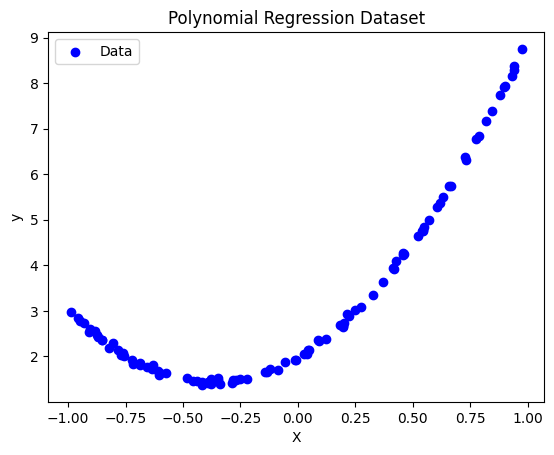

In [217]:
import numpy as np
import matplotlib.pyplot as plt

# Generate polynomial data
def generate_polynomial_data(n_samples=100, noise=0.1):
    np.random.seed(42)  # For reproducibility
    X = np.random.uniform(-1, 1, size=(n_samples, 1))  # Inputs in range [-1, 1]
    y = 4 * X**2 + 3 * X + 2  # Polynomial: y = 4x^2 + 3x + 2
    y += np.random.randn(n_samples, 1) * noise  # Add noise
    return X, y

# Generate data
X_train, y_train = generate_polynomial_data(n_samples=100, noise=0.05)

# Visualize data
plt.scatter(X_train, y_train, color="blue", label="Data")
plt.title("Polynomial Regression Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [238]:
# Normalize inputs and outputs to range [-1, 1]
X_train = X_train.astype(float)

X_train = (X_train - np.mean(X_train)) / np.std(X_train)  # Normalize inputs

# Convert to lists of lists for your NN
X_toTrain = X_train.tolist()

# Convert y_toTrain to a numpy array for easier manipulation

# Normalize to [-1, 1]
y_min, y_max = y_train.min(), y_train.max()
y_toTrain_normalized = 2 * (y_train - y_min) / (y_max - y_min) - 1

# Convert back to list of lists of `Value` objects for training
y_toTrain = [Value(float(y)) for y in y_toTrain_normalized]



/var/folders/8q/dh03ws3n0yx6gdjsn87pxb3c0000gn/T/ipykernel_20436/2628262265.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_toTrain = [Value(float(y)) for y in y_toTrain_normalized]


In [234]:
y_toTrain

[[Value(data=-0.9642708602756596, grad=0.0)],
 [Value(data=0.7795317475611028, grad=0.0)],
 [Value(data=-0.21804151388806003, grad=0.0)],
 [Value(data=-0.6540826297315989, grad=0.0)],
 [Value(data=-0.8789628200744316, grad=0.0)],
 [Value(data=-0.8711164832577265, grad=0.0)],
 [Value(data=-0.681520556236382, grad=0.0)],
 [Value(data=0.3397667506965816, grad=0.0)],
 [Value(data=-0.6319890997492401, grad=0.0)],
 [Value(data=-0.31060330883704546, grad=0.0)],
 [Value(data=-0.6003297431246437, grad=0.0)],
 [Value(data=0.8958480443546377, grad=0.0)],
 [Value(data=0.18261105463003835, grad=0.0)],
 [Value(data=-0.9316926830173675, grad=0.0)],
 [Value(data=-0.9067961054313698, grad=0.0)],
 [Value(data=-0.8967678422561494, grad=0.0)],
 [Value(data=-0.9913503518167206, grad=0.0)],
 [Value(data=-0.7912706886346489, grad=0.0)],
 [Value(data=-0.9255993762057667, grad=0.0)],
 [Value(data=-1.0, grad=0.0)],
 [Value(data=-0.589655966314196, grad=0.0)],
 [Value(data=-0.848847721007846, grad=0.0)],
 [Value

In [241]:
mlp = MLP(1, [16, 8, 1], activation='tanh', loss_function='mse')

In [242]:
optimizer = AdamOptimizer(mlp.getParams(), alpha=5e-3)

In [250]:
mlp.train(X_toTrain, y_toTrain, optimizer, max_iter=751, batch_processing=False)

Epoch 0, Loss = 0.05183211275001698
Epoch 50, Loss = 0.050306942708337944
Epoch 100, Loss = 0.048880495286256986
Epoch 150, Loss = 0.0475443681439214
Epoch 200, Loss = 0.04629119097577188
Epoch 250, Loss = 0.045114447393058636
Epoch 300, Loss = 0.04400832811392341
Epoch 350, Loss = 0.042967610849346555
Epoch 400, Loss = 0.041987562791357444
Epoch 450, Loss = 0.041063862111264976
Epoch 500, Loss = 0.04019253534564289
Epoch 550, Loss = 0.03936990797158137
Epoch 600, Loss = 0.0385925658431255
Epoch 650, Loss = 0.037857325478483375
Epoch 700, Loss = 0.037161211458460505
Epoch 750, Loss = 0.03650143942942328


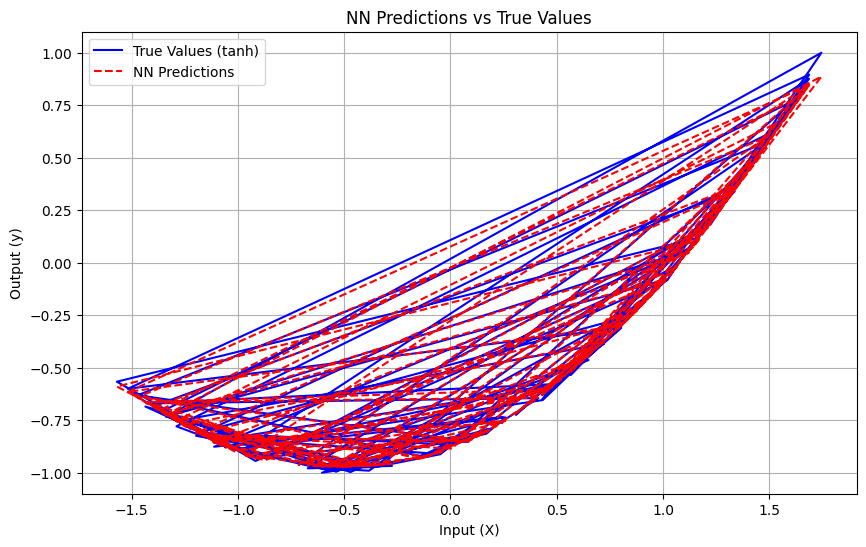

In [251]:
predictions = [mlp(x).data for x in X_toTrain]  # Replace `mlp` with your trained model instance
true_values = [y.data for y in y_toTrain]

# Visualize predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in X_toTrain], true_values, label="True Values (tanh)", color="blue")
plt.plot([x[0] for x in X_toTrain], predictions, label="NN Predictions", color="red", linestyle="dashed")
plt.title("NN Predictions vs True Values")
plt.xlabel("Input (X)")
plt.ylabel("Output (y)")
plt.legend()
plt.grid()
plt.show()


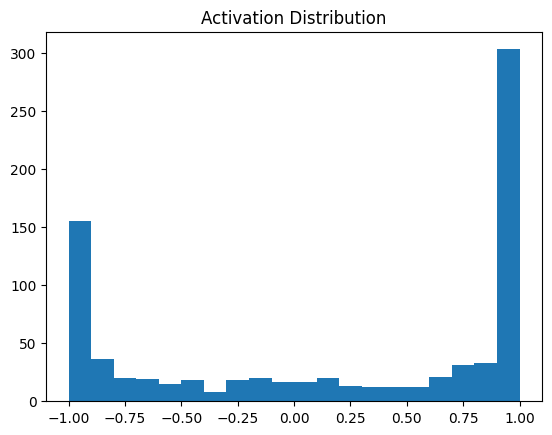

In [231]:
activations = [neuron(x).data for x in X_train for neuron in mlp.layers[0].neurons]
plt.hist(activations, bins=20)
plt.title("Activation Distribution")
plt.show()
